# bus proyect 

## step 1: initialization
### library importation, constant definition and data loading from files

modules import

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
%pylab inline
from math import sin, cos, sqrt, atan2, radians
pd.set_option('precision', 2)
from functools import reduce
import os
from operator import truediv


Populating the interactive namespace from numpy and matplotlib


constants definition

In [2]:
lower_limit_time_range=1200
upper_limit_time_range=1400
line_frequency_bound=10
T = 120
quantile_freq = 0.1
bus_capacity = 5

DEBUG = True


loading data from files - static information from catalogodatos.gub.uy

In [3]:
# https://catalogodatos.gub.uy/dataset/horarios-omnibus-urbanos-por-parada-stm
bus_schedules_by_stops = pd.read_csv('files/uptu_pasada_variante.csv',sep=';')

# https://catalogodatos.gub.uy/dataset/horarios-omnibus-urbanos-por-parada-stm
uptu_pasada_circular = pd.read_csv('files/uptu_pasada_circular.csv',sep=';')

# https://catalogodatos.gub.uy/dataset/transporte-colectivo-paradas-y-puntos-de-control
stops_ubication = gpd.read_file('files/v_uptu_paradas.shx')
stops_ubication = pd.DataFrame(stops_ubication)

# https://catalogodatos.gub.uy/dataset/transporte-colectivo-paradas-y-puntos-de-control
recorridos_omnibus = gpd.read_file('files/v_uptu_lsv.dbf')
recorridos_omnibus = pd.DataFrame(recorridos_omnibus)

# https://catalogodatos.gub.uy/dataset/transporte-colectivo-paradas-y-puntos-de-control
ubicacion_puntos_control = gpd.read_file('files/v_uptu_controles.dbf')
ubicacion_puntos_control = pd.DataFrame(ubicacion_puntos_control)

# https://catalogodatos.gub.uy/dataset/lineas-omnibus-origen-y-destino
origen_destino_lineas = gpd.read_file('files/v_uptu_lsv_destinos.dbf')
origen_destino_lineas = pd.DataFrame(origen_destino_lineas)

# https://catalogodatos.gub.uy/dataset/lineas-omnibus-origen-y-destino
recorridos_variantes_no_maximales = gpd.read_file('files/uptu_variante_no_maximal.dbf')
recorridos_variantes_no_maximales = pd.DataFrame(recorridos_variantes_no_maximales)

if DEBUG:
    display(bus_schedules_by_stops.head())





,tipo_dia,cod_variante,frecuencia,cod_ubic_parada,ordinal,hora,dia_anterior
0,1,7929,9230,6301,1,923,N
1,1,7929,9230,6196,2,924,N
2,1,7929,9230,2315,3,925,N
3,1,7929,9230,2316,4,926,N
4,1,7929,9230,2317,5,926,N


loading data from files - demand for defined period from Renzo (TODO: it should be calculated )

In [4]:
# TODO: pedir a Renzo el calculo de esto

#file_name='files/trasbordos.csv'
#transfers = pd.read_csv(file_name,sep=',')
#transfers.columns = ['stop_id_1','stop_id_2','line_id_1','line_id_2','n_transfers']
#transfers_all_day = transfers

#file_name='files/trasbordos_' + str(lower_limit_time_range) + '_' + str(upper_limit_time_range) +'.csv'
#transfers = pd.read_csv(file_name,sep=',')
#transfers.columns = ['stop_id_1','stop_id_2','line_id_1','line_id_2','n_transfers']
#transfers_1200_1400 = transfers

#SOLO ESTE SE USA
file_name='files/trasbordos_1200_1400_200.csv'
transfers = pd.read_csv(file_name,sep=',')
transfers.columns = ['stop_id_1','stop_id_2','line_id_1','line_id_2','n_transfers']
trasbordos_1200_1400_200 = transfers




## step 2: proccesing

the representation of the scenario is the following (output file structure): 

4 3 120 //lines sync_points period

1 2 2 100 3 10 15 16 0 // line1 line2 dist demand wb Wb TTl1 TTl2 bach

2 3 1  50 5  8 18 22 0

3 4 1  75 5  8 18 22 0

5 15

4 12

4 10

4 10


lines with low frecuency are filtered (if it are below line_frequency_bound )

'ordinal==1' is the first bus stop

In [5]:
bus_schedules_by_stops_aux = bus_schedules_by_stops.query('ordinal==1').copy()
bus_schedules_by_stops_aux['count'] = 1
bus_schedules_by_stops_aux = bus_schedules_by_stops_aux.groupby('cod_variante').sum().reset_index()
bus_schedules_by_stops_aux=bus_schedules_by_stops_aux[bus_schedules_by_stops_aux
                                                      ['count'] > line_frequency_bound]['cod_variante']
bus_schedules_by_stops = bus_schedules_by_stops[bus_schedules_by_stops['cod_variante']
                                                .isin(bus_schedules_by_stops_aux)]

Same filter for transtfers

In [6]:
def filter_transfers(transfers):
    transfers = transfers[transfers['line_id_1'].isin(bus_schedules_by_stops_aux)] 
    transfers = transfers[transfers['line_id_2'].isin(bus_schedules_by_stops_aux)]
    return transfers

#transfers_all_day_with_max = filter_transfers(transfers_all_day_with_max)
#transfers_1200_1400 = filter_transfers(transfers_1200_1400)
trasbordos_1200_1400_200 = filter_transfers(trasbordos_1200_1400_200)
#trasbordos_1200_1400_200



plotting some bus stop data for instance

In [7]:
#time1-time2
def min_desde_cero(time):
    hours = time // 100
    minutes = time % 100
    minutos_desde_la_cero_hora=hours*60+minutes
    return minutos_desde_la_cero_hora

#if DEBUG:
    #horas = bus_schedules_by_stops.query("cod_variante==7929 and cod_ubic_parada == 582").copy()
    #horas['min_desde_cero'] = horas.apply(lambda e: min_desde_cero(e.hora),axis = 1)
    #horas = horas.sort_values(by=['frecuencia'])
    #horas['min_desde_cero'].plot()

complete transfers with parents lines, through merging with recorridos_variantes_no_maximales

In [8]:
#display(recorridos_variantes_no_maximales.head())

def complete_maximals(transfers):
    transfers_with_no_max = transfers.copy()
    transfers_with_no_max =  pd.merge(transfers_with_no_max, recorridos_variantes_no_maximales, 
                     how='left', left_on=['line_id_1'], right_on=['COD_VARIAN'])
    transfers_with_no_max = transfers_with_no_max[['stop_id_1','stop_id_2',
                                                   'line_id_1','line_id_2','n_transfers',
                                                  'COD_VAR_01',]]
    transfers_with_no_max.columns = ['stop_id_1','stop_id_2',
                                                   'line_id_1','line_id_2','n_transfers',
                                                  'line_id_1_var_01',]

    transfers_with_no_max =  pd.merge(transfers_with_no_max, recorridos_variantes_no_maximales, 
                     how='left', left_on=['line_id_2'], right_on=['COD_VARIAN'])

    transfers_with_no_max = transfers_with_no_max[['stop_id_1','stop_id_2',
                                                   'line_id_1','line_id_2','n_transfers','line_id_1_var_01',
                                                  'COD_VAR_01',]]
    transfers_with_no_max.columns = ['stop_id_1','stop_id_2',
                                                   'line_id_1','line_id_2','n_transfers',
                                                  'line_id_1_var_01','line_id_2_var_01',]

    transfers_with_no_max['line_id_1_var_01'] =\
                transfers_with_no_max.apply(lambda e: e.line_id_1 
                                            if math.isnan(e.line_id_1_var_01)
                                            else e.line_id_1_var_01,axis = 1) 

    transfers_with_no_max['line_id_2_var_01'] =\
                transfers_with_no_max.apply(lambda e: e.line_id_2 
                                            if math.isnan(e.line_id_2_var_01) 
                                            else e.line_id_2_var_01,axis = 1)
    return transfers_with_no_max

transfers_1200_1400_with_max_200 = complete_maximals(trasbordos_1200_1400_200)


calculate tt (travel time)

In [9]:
#time1-time2
def diff(time1,time2):
    hours1 = time1 // 100
    minutes1 = time1 % 100
    hours2 = time2 // 100
    minutes2 = time2 % 100
    minutos_desde_la_cero_hora1=hours1*60+minutes1
    minutos_desde_la_cero_hora2=hours2*60+minutes2
    return minutos_desde_la_cero_hora2 - minutos_desde_la_cero_hora1

def obtener_hora_de_salida(frecuencia,bus):
    bus=bus[bus.ordinal == 1]
    bus=bus[bus['frecuencia'] ==  frecuencia]
    bus=bus[bus['tipo_dia'] ==  1]
    bus=bus[bus['dia_anterior'] ==  'N'].copy().reset_index()
    return bus['hora']

def tt(linea,parada,bus_schedules_by_stops):
    
    query_this_line = "cod_variante == "+ str(linea) + " and tipo_dia == 1 and dia_anterior == 'N'"
    
    
    query_this_line_and_stop = "cod_variante == "+ str(linea) + \
        " and cod_ubic_parada == " + str(parada) + " and tipo_dia == 1 and dia_anterior == 'N'"
        
        
        
    bus_schedules_by_stops_this_line = bus_schedules_by_stops.query(query_this_line)
    bus_schedules_by_stops_this_line_and_stop = bus_schedules_by_stops.query(query_this_line_and_stop)
    
    
    hour_threshold_frecuencies = bus_schedules_by_stops_this_line.query('tipo_dia == 1 and ordinal==1 and hora >=' +
                                             str(lower_limit_time_range-400) +
                                            'and hora <= ' + str(upper_limit_time_range+400)
                                            ).copy()
    
    
    
    bus_schedules_by_stops_this_line =\
    bus_schedules_by_stops_this_line[bus_schedules_by_stops_this_line
                                     ['frecuencia'].isin(hour_threshold_frecuencies['frecuencia'])]
    bus_schedules_by_stops_this_line_and_stop =\
    bus_schedules_by_stops_this_line_and_stop[bus_schedules_by_stops_this_line_and_stop
                                              ['frecuencia'].isin(hour_threshold_frecuencies['frecuencia'])]
    
    if (bus_schedules_by_stops_this_line_and_stop.size>0):
    
        bus_schedules_by_stops_this_line_and_stop['hora_salida'] =\
        bus_schedules_by_stops_this_line_and_stop.apply(lambda e: obtener_hora_de_salida(e.frecuencia,\
        bus_schedules_by_stops_this_line),axis = 1) 

        bus_schedules_by_stops_this_line_and_stop['TT'] =\
        bus_schedules_by_stops_this_line_and_stop.apply(lambda e: diff(e.hora_salida,e.hora),axis = 1) 

        #    aux2 =\
        #    aux2.groupby(['tipo_dia','cod_variante','cod_ubic_parada']).mean().reset_index()
        #    query='cod_variante=='+ str(linea) +' and cod_ubic_parada == '+str(parada)#+' and tipo_dia == 1 '
        #    aaa= aux2.query(query)['TT']
        #    return aaa

        bus_schedules_by_stops_this_line_and_stop =\
        bus_schedules_by_stops_this_line_and_stop.groupby(['tipo_dia','cod_variante','cod_ubic_parada']).mean().reset_index()
        query='cod_variante=='+ str(linea) +' and cod_ubic_parada == '+str(parada)#+' and tipo_dia == 1 '
        bus_schedules_by_stops_this_line_and_stop= bus_schedules_by_stops_this_line_and_stop.query(query)['TT']
        return bus_schedules_by_stops_this_line_and_stop
    
    #display(bus_schedules_by_stops_this_line_and_stop.head())

    
    else:
        return -1

def add_tt1_tt2(transfers_with_no_max):        
    transfers_with_no_max['TT1'] =\
    transfers_with_no_max.apply(lambda e: 
                                         tt(e.line_id_1,e.stop_id_1,bus_schedules_by_stops),axis = 1).copy() 
    transfers_with_no_max['TT2'] =\
            transfers_with_no_max.apply(lambda e: tt(e.line_id_2,e.stop_id_2,
                                                      bus_schedules_by_stops),axis = 1).copy() 
    
    _aux = transfers_with_no_max.query('TT1 < 0 or TT2 < 0')
    _aux = _aux.reset_index()
    #display(_aux)
    #display(len(_aux.index))
        
    if _aux.size > 0:
        print("oops... i could not calculate TTL for "+ str(len(_aux.index)) + " lines. It going to be discarted")
    
    transfers_with_no_max = transfers_with_no_max.query('TT1 >= 0 and TT2 >= 0')
    
    
    return transfers_with_no_max


transfers_1200_1400_max_tts_200 = add_tt1_tt2(transfers_1200_1400_with_max_200).copy()



/home/jon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/jon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


oops... i could not calculate TTL for 2 lines. It going to be discarted


merge transfers and stops ubication to get stops geometriy (coordinates)

In [10]:
def add_sptop_coors(transfers_with_no_max):    
    transfers_with_stop_coors = transfers_with_no_max.copy()
    transfers_with_stop_coors =  pd.merge(transfers_with_stop_coors, stops_ubication, 
                     how='left', left_on=['stop_id_1','line_id_1_var_01'], right_on=['COD_UBIC_P',
                                                                                     'COD_VARIAN'])
    transfers_with_stop_coors = transfers_with_stop_coors[['line_id_1','line_id_2','stop_id_1',
                                                           'stop_id_2','line_id_1_var_01',
                                                             'line_id_2_var_01','n_transfers','geometry','TT1','TT2']]
    transfers_with_stop_coors.columns = ['line_id_1','line_id_2','stop_id_1','stop_id_2',
                                         'line_id_1_var_01','line_id_2_var_01','n_transfers',
                                          'line_1_geometry','TT1','TT2']
    transfers_with_stop_coors = pd.merge(transfers_with_stop_coors, stops_ubication, 
                     how='left', left_on=['stop_id_2','line_id_2_var_01'], right_on=['COD_UBIC_P',
                                                                                     'COD_VARIAN'])
    transfers_with_stop_coors = transfers_with_stop_coors[['line_id_1','line_id_2','stop_id_1',
                                                           'stop_id_2','line_id_1_var_01',
                                                             'line_id_2_var_01','n_transfers',
                                                           'line_1_geometry','geometry','TT1','TT2']]
    transfers_with_stop_coors = transfers_with_stop_coors[['line_id_1',
                                                             'line_id_2','n_transfers',
                                                             'line_1_geometry',
                                                             'geometry','TT1','TT2']]
    transfers_with_stop_coors.columns = ['line_id_1',
                                        'line_id_2','n_transfers','line_1_geometry',
                                        'line_2_geometry','TT1','TT2']
    return transfers_with_stop_coors

transfers_1200_1400_max_tts_coors_200 = add_sptop_coors(transfers_1200_1400_max_tts_200)

if DEBUG:
    display(transfers_1200_1400_max_tts_coors_200.head(1))




,line_id_1,line_id_2,n_transfers,line_1_geometry,line_2_geometry,TT1,TT2
0,1759,2422,31,POINT (576647.11472 6148135.18576),POINT (576793.9282862354 6147779.394846829),26.33,1.0


plotting stops

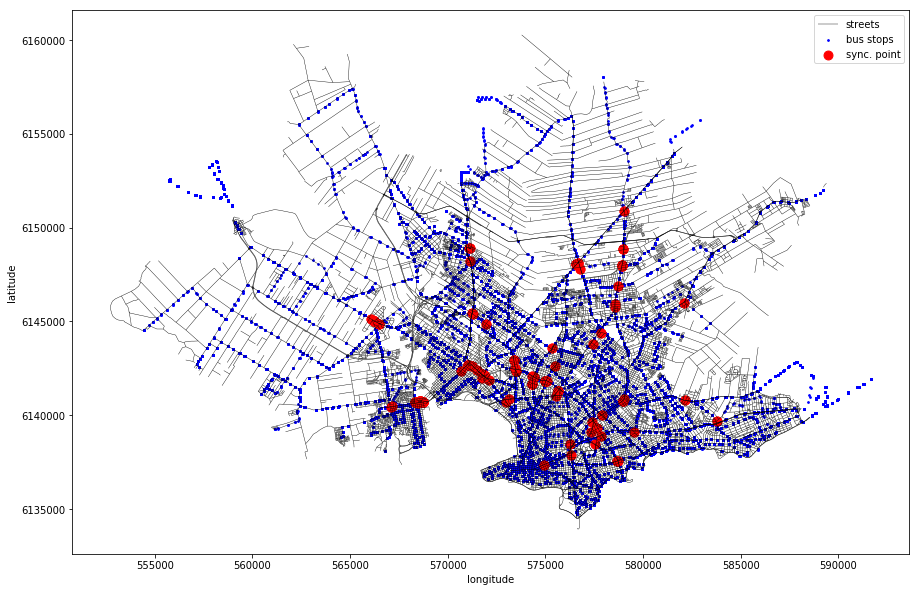

In [11]:
if DEBUG:
    #in
    transfers_with_stop_coors = transfers_1200_1400_max_tts_coors_200

    gdf_bus_stops=gpd.read_file("files/v_uptu_paradas/v_uptu_paradas.shp")
    #gdf_bus_stops=gdf_bus_stops.to_crs(epsg=4326) 
    gdf_streets=gpd.read_file("files/v_mdg_vias/v_mdg_vias.shp")
    #gdf_streets=gdf_streets.to_crs(epsg=4326) 
    bus_schedules_by_stops_aux = bus_schedules_by_stops.copy()
    bus_schedules_by_stops_aux = bus_schedules_by_stops_aux.groupby(['cod_variante','cod_ubic_parada'], sort=False).max().reset_index()

    #bus_schedules_by_stops_aux = pd.merge(bus_schedules_by_stops_aux, frequency, 
    #                 how='right', left_on=['cod_variante'], right_on=['linea'])

    gdf_bus_stops = pd.merge(gdf_bus_stops, bus_schedules_by_stops_aux, 
                     how='right', left_on=['COD_UBIC_P'], right_on=['cod_ubic_parada'])

    geometry = transfers_with_stop_coors['line_1_geometry']
    crs = {'init': 'epsg:4326'}
    syncs1 = gpd.GeoDataFrame(transfers_with_stop_coors, crs=crs, geometry=geometry)
    geometry = transfers_with_stop_coors['line_2_geometry']
    crs = {'init': 'epsg:4326'}
    syncs2 = gpd.GeoDataFrame(transfers_with_stop_coors, crs=crs, geometry=geometry)
    fig, ax = plt.subplots(figsize=(15, 10))
    gdf_streets.plot(ax=ax,linewidth=0.4,color="black",label="streets")
    gdf_bus_stops.plot(ax=ax,color="blue",markersize=3,label="bus stops")
    syncs = syncs1.append(syncs2)
    syncs.plot(ax=ax,color="red",markersize=80,label="sync. point")
    plt.legend()
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.rcParams.update({'font.size': 12})
    #display(gdf_bus_stops.head())
    plt.savefig("figs/paradas_buses.png", bbox_inches='tight')


caculate distance between stops of lines

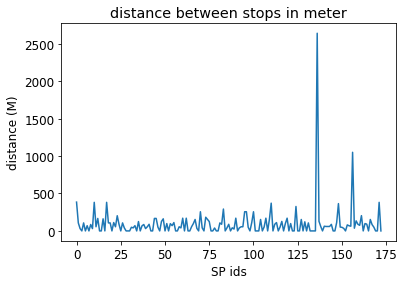

In [12]:
def dist(geometry_1,geometry_2):
    return geometry_1.distance(geometry_2)

def add_dist(transfers_with_stop_coors):
    transfers_with_stop_coors['dist'] =\
    transfers_with_stop_coors.apply(lambda e:dist(e.line_1_geometry,e.line_2_geometry),axis = 1) 
    transfers_with_stop_coors.head(20)
    return transfers_with_stop_coors
    
#transfers_all_day_max_tts_coors_dist = add_dist(transfers_all_day_max_tts_coors)
#transfers_1200_1400_max_tts_coors_dist = add_dist(transfers_1200_1400_max_tts_coors)
transfers_1200_1400_max_tts_coors_dist_200 = add_dist(transfers_1200_1400_max_tts_coors_200)

if DEBUG:
    #display(transfers_all_day_max_tts_coors_dist.head(1))
    #display(transfers_1200_1400_max_tts_coors_dist.head(1))
    #display(transfers_1200_1400_max_tts_coors_dist_200.head(1))
    ax = transfers_1200_1400_max_tts_coors_dist_200['dist'].plot(
        title='distance between stops in meter')
    ax.set_xlabel("SP ids")
    ax.set_ylabel("distance (M)")
    

## Format points input file

intersection points

In [13]:
def dist(transfers_with_stop_coors):
    points = transfers_with_stop_coors[['line_id_1','line_id_2','dist','n_transfers','TT1','TT2']]
    points.columns = ['line_i','line_j','dist','demand','TT_i','TT_j']
    points.insert(4, 'wb',5)
    points.insert(5, 'wB', 10)
    #points.insert(6, 'TT_i', np.zeros(len(points)))
    #points.insert(7, 'TT_j', np.zeros(len(points)))
    points.insert(8, 'BP', np.zeros(len(points)))
    return points

#points_all_day = dist(transfers_all_day_max_tts_coors_dist)
#points_1200_1400 = dist(transfers_1200_1400_max_tts_coors_dist)
points_1200_1400_200 = dist(transfers_1200_1400_max_tts_coors_dist_200)

if DEBUG:
    #display(points_all_day.head(1))
    #display(points_1200_1400.head())
    display(points_1200_1400_200.head())



,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,1759,2422,384.89,31,5,10,26.33,1.0,0.0
1,170,1290,107.06,30,5,10,21.75,0.0,0.0
2,2050,1418,31.01,30,5,10,8.13,2.0,0.0
3,1117,170,0.00,28,5,10,84.56,0.0,0.0
4,2411,1290,107.06,25,5,10,39.75,0.0,0.0


frequency

justificar modelo de frecuencias constantes calculando promedio y desviacion respecto a frecuencias reales


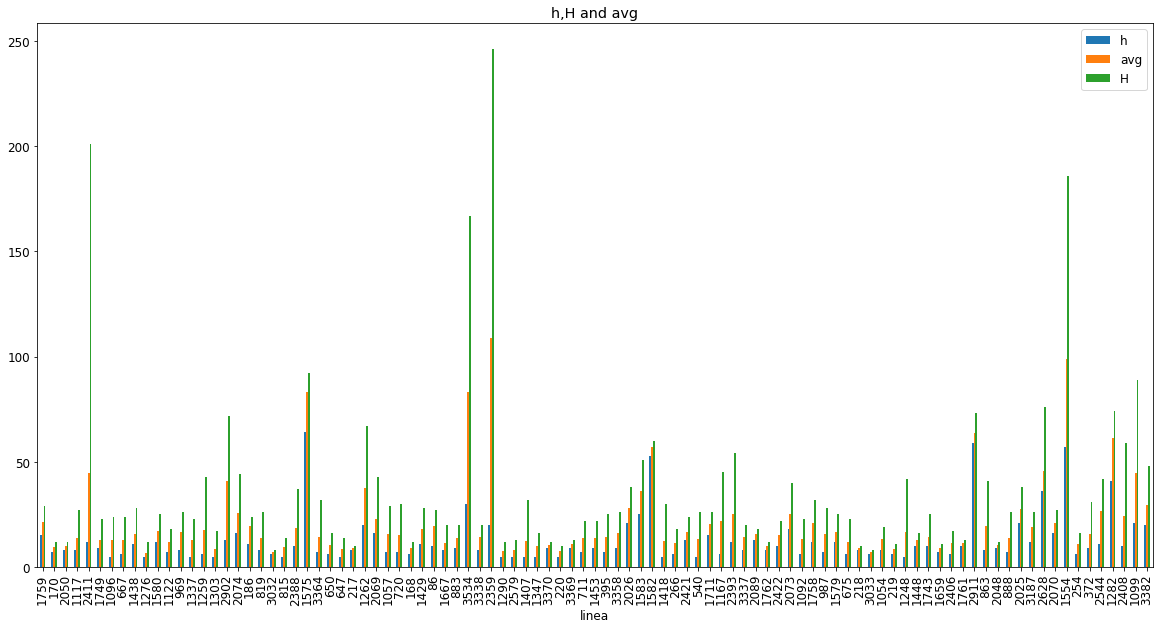

In [14]:
def max_min_avg_line_frec( linea ,bus_schedules_by_stops,lower_limit_time_range,upper_limit_time_range):
    resultado=bus_schedules_by_stops.query('tipo_dia==1 and ordinal==1 and dia_anterior== "N" and cod_variante=='
                                           +str(linea)+
                                           ' and hora>='+str(lower_limit_time_range-400)+' and hora<='
                                           +str(upper_limit_time_range+400))
    
    
    #print(resultado.query('cod_variante == 1276')['hora'])
    

    resultadoHoraTolistSinRepetidos=list(set(resultado.hora.tolist()))
    resultadoHoraTolistSinRepetidos = sorted(resultadoHoraTolistSinRepetidos)
    cant_rows = len(resultadoHoraTolistSinRepetidos)
    
    maxima_fecuencia = 0
    minima_frecuencia = 10000000
    lista_frecuencias_minutos_linea=[]
    
    for i in range(cant_rows-1):
        time1=resultadoHoraTolistSinRepetidos[i]
        time2=resultadoHoraTolistSinRepetidos[i+1]
        hours1 = time1 // 100
        minutes1 = time1 % 100
        hours2 = time2 // 100
        minutes2 = time2 % 100
        minutos_desde_la_cero_hora1=hours1*60+minutes1
        minutos_desde_la_cero_hora2=hours2*60+minutes2
        resta = minutos_desde_la_cero_hora2-minutos_desde_la_cero_hora1
        lista_frecuencias_minutos_linea.append(resta)
        if(maxima_fecuencia<resta):
            maxima_fecuencia=resta
    #elimina los duplicados    
    lista_frecuencias_minutos_linea = list(set(lista_frecuencias_minutos_linea)) 
    

    
    
    retornero =	{
      "min": min(lista_frecuencias_minutos_linea),
      "max": maxima_fecuencia,
      "avg": sum(lista_frecuencias_minutos_linea)/len(lista_frecuencias_minutos_linea)
    }
    return retornero

def frequencies(points):

    lista_min = []
    lista_max = []
    lista_avg = []
    lineas_en_orden_procesado=[]



    # list of used stops
    aux_lines_i =  pd.DataFrame({'linea': points['line_i'] })
    aux_lines_j =  pd.DataFrame({'linea': points['line_j'] })
    aux_lines = aux_lines_i.append(aux_lines_j)
    aux_lines = aux_lines.drop_duplicates(subset=None, keep='first', inplace=False)
    frequency = aux_lines.copy()

    #display(lista_linea)

    for i in range(len(frequency)):
       lista_linea=frequency.linea.tolist()
       min_max_promedio= max_min_avg_line_frec(lista_linea[i],bus_schedules_by_stops,
                                               lower_limit_time_range,upper_limit_time_range)
       lista_min.append(min_max_promedio["min"])
       lista_max.append(min_max_promedio["max"])
       lista_avg.append(min_max_promedio["avg"])
       lineas_en_orden_procesado.append(lista_linea[i])

    lineas_min_max_avg=pd.DataFrame({'linea': lineas_en_orden_procesado, 'h': lista_min, 'H': lista_max, 'avg': lista_avg})

    
    
    
    frec_h_H_avg =  pd.merge(frequency, lineas_min_max_avg, 
                     how='left', left_on=['linea'], right_on=['linea'])
    
    # limpieza
    
    quantile = frec_h_H_avg['h'].quantile(quantile_freq)    
    frec_h_H_avg['h'] = frec_h_H_avg.apply(lambda e: int(math.ceil(quantile)) if e.h < quantile else int(e.h),axis = 1)
    
    #display(pd.DataFrame(data={'h': lista_frecuencias_minutos_linea}).quantile(0.05))
    #display(min(lista_frecuencias_minutos_linea))
    
    return frec_h_H_avg

#frequencies_all_day = frequencies(points_all_day)
#frequencies_1200_1400 = frequencies(points_1200_1400)
frequencies_1200_1400_200 = frequencies(points_1200_1400_200)

if DEBUG:
    #display(frequencies_all_day.head(20))
    #display(frequencies_1200_1400.head())
    #display(frequencies_1200_1400_200.shape[0])
    frequencies_1200_1400_200.plot(title="h,H and avg",x="linea", y=["h", "avg","H"], kind="bar",figsize=(20,10))
    ax.set_xlabel("line")
    ax.set_ylabel("minutes")



calculate W w

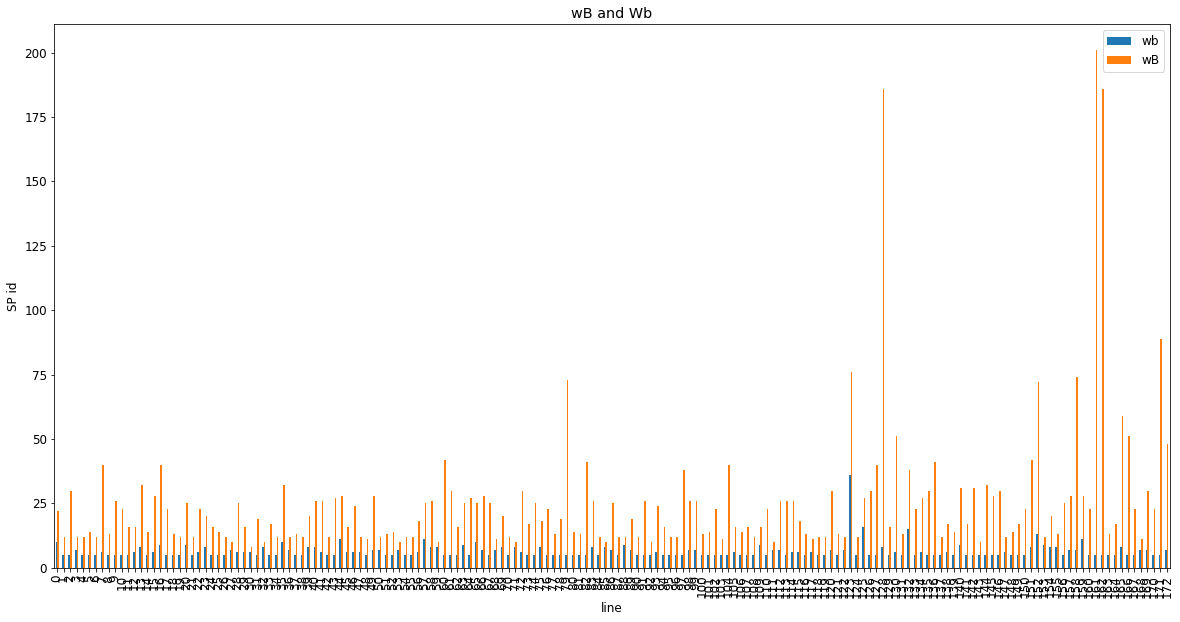

In [15]:
def add_ws(points,frecs):

    points_merge_frec_h_H_avg_i= pd.merge(points, frecs, 
                               how='left', left_on=['line_i'], right_on=['linea'])

    points_merge_frec_h_H_avg_j= pd.merge(points, frecs, 
                               how='left', left_on=['line_j'], right_on=['linea'])

    #muestro tabla de frequencys para parejas de lineas
    frecueni_j=pd.DataFrame({'line_i': points.line_i.tolist(),
                         'line_j': points.line_j.tolist(),
                         'h_i': points_merge_frec_h_H_avg_i.h.tolist(),
                         'Hi': points_merge_frec_h_H_avg_i.H.tolist(),
                         'h_j': points_merge_frec_h_H_avg_j.h.tolist(),
                         'Hj': points_merge_frec_h_H_avg_j.H.tolist(),
                         'avg_i': points_merge_frec_h_H_avg_i.avg.tolist(),
                         'avg_j': points_merge_frec_h_H_avg_j.avg.tolist()

                          }) 


    #display(frecueni_j)

    #wb es el minimo de los h de las dos lineas del punto
    minimasFrecs=[]
    for i in range(len(frecueni_j)):
        minimasFrecs.append(min(points_merge_frec_h_H_avg_i.h.tolist()[i],points_merge_frec_h_H_avg_j.h.tolist()[i]))

    #display(frec_h_H_avg.H.tolist())
    #display(points_merge_frec_h_H_avg)
    #wB se setea por el H de la frequency 
    points=pd.DataFrame({'line_i': points.line_i.tolist(),
                         'line_j': points.line_j.tolist(),
                         'dist': points.dist.tolist(),
                         'demand': points.demand.tolist(),
                         'wb': minimasFrecs,
                         'wB': points_merge_frec_h_H_avg_j.H.tolist(),
                         'TT_i': points.TT_i.tolist(),
                         'TT_j': points.TT_j.tolist(),
                         'BP': points.BP.tolist(),
                          })  
    return points
    
#points_all_day = add_ws(points_all_day,frequencies_all_day)
#points_1200_1400 = add_ws(points_1200_1400,frequencies_1200_1400)
points_1200_1400_200 = add_ws(points_1200_1400_200,frequencies_1200_1400_200)


if DEBUG:
    #display(frequencies_all_day.head(20))
    #display(frequencies_1200_1400.head())
    #display(frequencies_1200_1400_200.shape[0])
    ax = points_1200_1400_200.plot(title="wB and Wb",y=["wb", "wB"], kind="bar",figsize=(20,10))
    ax.set_xlabel("line")
    ax.set_ylabel("SP id")
    

#display(points_all_day.head(2))
#display(points_1200_1400.head(2))
#display(points_1200_1400_200.head(2))    

filtering lines that arrive out of period

In [16]:
#def esta_en_freq(linea,frecs):
#    return len(frecs[frecs['linea'] == linea])

#def filter_out_of_period(points,frecs):
#    frecs = frecs[frecs['avg'] < 60]
#    frecs = frecs[frecs['H'] < 120]
#    points['i_ok'] = points.apply(lambda e: esta_en_freq(e.line_i,frecs),axis = 1)
#    points['j_ok'] = points.apply(lambda e: esta_en_freq(e.line_j,frecs),axis = 1)
#    points=points[points['i_ok'] == 1 & points['j_ok']]
#    points = points[['line_i','line_j','dist','demand','wb','wB','TT_i','TT_j','BP']]
#    lineas_en_puntos =   points.line_i.append(points.line_j)
#    frecs = frecs[frecs['linea'].isin(lineas_en_puntos)]
#    frecs = frecs.copy()
#    points = points.copy()
#    return points,frecs


int(ceil) to distance and time travel


In [17]:
def to_int_ceil(points):
    points['dist'] = points.apply(lambda e:math.ceil(e.dist),axis = 1)
    points['TT_i'] = points.apply(lambda e:math.ceil(e.TT_i),axis = 1) 
    points['TT_j'] = points.apply(lambda e:math.ceil(e.TT_j),axis = 1) 
    points['BP'] = points.apply(lambda e:math.ceil(e.BP),axis = 1) 
    return points
    
#points_1200_1400 = to_int_ceil(points_1200_1400)
#points_all_day = to_int_ceil(points_all_day)
points_1200_1400_200 = to_int_ceil(points_1200_1400_200)

if DEBUG:
    display(points_1200_1400_200.head())


,line_i,line_j,dist,demand,wb,wB,TT_i,TT_j,BP
0,1759,2422,385,31,10,22,27,1,0
1,170,1290,108,30,5,12,22,0,0
2,2050,1418,32,30,5,30,9,2,0
3,1117,170,0,28,7,12,85,0,0
4,2411,1290,108,25,5,12,40,0,0


# scenario generation

In [18]:
scenario_array = [None] * (15)

def get_escenario(points_1200_1400_200,size,random_state, my_lambda, ordinal):
    _points_aux1 = points_1200_1400_200.sample(size,random_state=random_state).copy()
    points_aux1 = _points_aux1.copy()
    points_aux1['wB'] = _points_aux1['wB'] * my_lambda
    points_aux1['wB'] = points_aux1.apply(lambda e:math.ceil(e.wB),axis = 1)
    points_aux1 = points_aux1.reset_index()
    points_aux1 = points_aux1.drop(columns='index')
    frequencies_aux1 = frequencies_1200_1400_200.copy()
    lineas_en_puntos = points_aux1.line_i.append(points_aux1.line_j)
    frequencies_aux1 = frequencies_aux1[frequencies_aux1['linea'].isin(lineas_en_puntos)]
    frequencies_aux1 = frequencies_aux1.reset_index()
    frequencies_aux1 = frequencies_aux1.drop(columns='index')
    scenario_array = {'name':'BS.12-14.'+str(size)+'.' + 
                      str(len(frequencies_aux1))+'.120.' +  str(int(my_lambda * 100) ) + '.'+ str(ordinal),
                     'ps':points_aux1,'fs':frequencies_aux1}
    return scenario_array


### GRUPO A

chicos 75, 90, 100


In [19]:
scenario_array[0] = get_escenario(points_1200_1400_200,30,1,1,0)
scenario_array[1] = get_escenario(points_1200_1400_200,30,2,1,1)
scenario_array[2] = get_escenario(points_1200_1400_200,30,3,1,2)
scenario_array[3] = get_escenario(points_1200_1400_200,30,4,1,3)
scenario_array[4] = get_escenario(points_1200_1400_200,30,5,1,4)

scenario_array[5] = get_escenario(points_1200_1400_200,30,6,0.9,0)
scenario_array[6] = get_escenario(points_1200_1400_200,30,7,0.9,1)
scenario_array[7] = get_escenario(points_1200_1400_200,30,8,0.9,2)
scenario_array[8] = get_escenario(points_1200_1400_200,30,9,0.9,3)
scenario_array[9] = get_escenario(points_1200_1400_200,30,10,0.9,4)

scenario_array[10] = get_escenario(points_1200_1400_200,30,11,0.75,0)
scenario_array[11] = get_escenario(points_1200_1400_200,30,12,0.75,1)
scenario_array[12] = get_escenario(points_1200_1400_200,30,13,0.75,2)
scenario_array[13] = get_escenario(points_1200_1400_200,30,14,0.75,3)
scenario_array[14] = get_escenario(points_1200_1400_200,30,15,0.75,4)



medianos

In [20]:
#scenario_array[15] = get_escenario(points_1200_1400_200,70,1,1,0)
#scenario_array[16] = get_escenario(points_1200_1400_200,70,2,1,1)
#scenario_array[17] = get_escenario(points_1200_1400_200,70,3,1,2)
#scenario_array[18] = get_escenario(points_1200_1400_200,70,4,1,3)
#scenario_array[19] = get_escenario(points_1200_1400_200,70,5,1,4)

#scenario_array[20] = get_escenario(points_1200_1400_200,70,6,0.9,0)
#scenario_array[21] = get_escenario(points_1200_1400_200,70,7,0.9,1)
#scenario_array[22] = get_escenario(points_1200_1400_200,70,8,0.9,2)
#scenario_array[23] = get_escenario(points_1200_1400_200,70,9,0.9,3)
#scenario_array[24] = get_escenario(points_1200_1400_200,70,10,0.9,4)

#scenario_array[25] = get_escenario(points_1200_1400_200,70,11,0.75,0)
#scenario_array[26] = get_escenario(points_1200_1400_200,70,12,0.75,1)
#scenario_array[27] = get_escenario(points_1200_1400_200,70,13,0.75,2)
#scenario_array[28] = get_escenario(points_1200_1400_200,70,14,0.75,3)
#scenario_array[29] = get_escenario(points_1200_1400_200,70,15,0.75,4)


grandes

In [21]:
#scenario_array[30] = get_escenario(points_1200_1400_200,110,1,1,0)
#scenario_array[31] = get_escenario(points_1200_1400_200,110,2,1,1)
#scenario_array[32] = get_escenario(points_1200_1400_200,110,3,1,2)
#scenario_array[33] = get_escenario(points_1200_1400_200,110,4,1,3)
#scenario_array[34] = get_escenario(points_1200_1400_200,110,5,1,4)

#scenario_array[35] = get_escenario(points_1200_1400_200,110,6,0.9,0)
#scenario_array[36] = get_escenario(points_1200_1400_200,110,7,0.9,1)
#scenario_array[37] = get_escenario(points_1200_1400_200,110,8,0.9,2)
#scenario_array[38] = get_escenario(points_1200_1400_200,110,9,0.9,3)
#scenario_array[39] = get_escenario(points_1200_1400_200,110,10,0.9,4)

#scenario_array[40] = get_escenario(points_1200_1400_200,110,11,0.75,0)
#scenario_array[41] = get_escenario(points_1200_1400_200,110,12,0.75,1)
#scenario_array[42] = get_escenario(points_1200_1400_200,110,13,0.75,2)
#scenario_array[43] = get_escenario(points_1200_1400_200,110,14,0.75,3)
#scenario_array[44] = get_escenario(points_1200_1400_200,110,15,0.75,4)


In [22]:
#def get_escenario_bactracking(points_1200_1400_200):
#    df1 = points_1200_1400_200[0:1]
#    df2 = points_1200_1400_200[25:26]
#    df3 = points_1200_1400_200[13:14]
#    df4 = points_1200_1400_200[24:25]
#    df5 = points_1200_1400_200[15:16]
#    df6 = points_1200_1400_200[31:32]
#    df7 = points_1200_1400_200[23:24]
#    frames = [df1, df2, df3,df4,df5,df6,df7]
    
#    _points_aux1 = pd.concat(frames)
    
#    size = 8
#    my_lambda = 0.75
#    ordinal = 0
#    points_aux1 = _points_aux1.copy()
#    points_aux1['wB'] = _points_aux1['wB'] * my_lambda
#    points_aux1['wB'] = points_aux1.apply(lambda e:math.ceil(e.wB),axis = 1)
#    points_aux1 = points_aux1.reset_index()
#    points_aux1 = points_aux1.drop(columns='index')
#    frequencies_aux1 = frequencies_1200_1400_200.copy()
#    lineas_en_puntos = points_aux1.line_i.append(points_aux1.line_j)
#    frequencies_aux1 = frequencies_aux1[frequencies_aux1['linea'].isin(lineas_en_puntos)]
#    frequencies_aux1 = frequencies_aux1.reset_index()
#    frequencies_aux1 = frequencies_aux1.drop(columns='index')
#    scenario_array = {'name':'BS.12-14.'+str(size)+'.' + 
#                      str(len(frequencies_aux1))+'.120.' +  str(int(my_lambda * 100) ) + '.'+ str(ordinal),
#                     'ps':points_aux1,'fs':frequencies_aux1}
#    return scenario_array

#scenario_array[45] = get_escenario_bactracking(points_1200_1400_200)

#scenario_array[45]['fs']



mapping (real line id -> correlative id)

In [23]:
def get_index(linea,mapeo_linea):
    d = mapeo_linea[mapeo_linea['linea']==linea]['id']
    return d.values[0]

def mapping(points,frec_h_H_avg):

    #recorrer frec_h_H_avg y agregar columna, luego agregar nuevas columnas a points
    mapeo_linea_id=[]
    #se construye mapeo
    rango_lineas_procesadas= range(0,len(frec_h_H_avg))
    mapeo_lineas = frec_h_H_avg.copy()
    mapeo_lineas['id'] = rango_lineas_procesadas
    
    points_map = points.copy()
    points_map['id_i'] = points.apply(lambda e: get_index(e.line_i,mapeo_lineas),axis = 1)
    points_map['id_j'] = points.apply(lambda e: get_index(e.line_j,mapeo_lineas),axis = 1)
    
    #construye nuevo dataframe con las columnas en otro orden
    points_con_ids=pd.DataFrame({
        'line_i_old': points_map.line_i.tolist(),
        'line_j_old': points_map.line_j.tolist(),        
        'line_i': points_map.id_i.tolist(),
                                 'line_j': points_map.id_j.tolist(),
                                 'dist': points_map.dist.tolist(),
                                 'demand': points_map.demand.tolist(),
                                 'wb': points_map.wb.tolist(),
                                 'wB': points_map.wB.tolist(),
                                 'TT_i': points_map.TT_i.tolist(),
                                 'TT_j': points_map.TT_j.tolist(),
                                 'BP': points_map.BP.tolist(),
                                  })  

    frec_h_H_avg_ids=pd.DataFrame({'linea': mapeo_lineas.id.tolist(),
                                   'h': mapeo_lineas.h.tolist(),
                                   'H': mapeo_lineas.H.tolist(),
                                   'avg': mapeo_lineas.avg.tolist()
                                  })  
    
    points_con_ids = points_con_ids[['line_i','line_j','dist','demand','wb','wB','TT_i','TT_j','BP',]]
    
    return points_con_ids, frec_h_H_avg_ids

#ps_m, fs_m = mapping(scenario_array[0]['ps'],scenario_array[0]['fs'])
#len(scenario_array)
for i in range(len(scenario_array)):
    ps_m, fs_m = mapping(scenario_array[i]['ps'],scenario_array[i]['fs'])
    scenario_array[i]['ps_m'] = ps_m
    scenario_array[i]['fs_m'] = fs_m
#if DEBUG:
#    display(scenario_array[9]['fs_m'].head())
#    display(scenario_array[9]['ps_m'].head())

# scenario validation

In [24]:
def validate(scenario):
    for e in scenario['ps_m']['line_i'].tolist():
        if not (e in scenario['fs_m']['linea'].tolist()):
            return False
    for e in scenario['ps_m']['line_j']:
        if not (e in scenario['fs_m']['linea']):
            return False
    for e in scenario['fs_m']['linea']:
        if e not in scenario['ps_m']['line_i'].tolist() and e not in scenario['ps_m']['line_j'].tolist():
            print(scenario['name'] + ' linea ' + str(e))
            return False
    #and so on ..    
    
    return True    

globalOk = True
for i in range(len(scenario_array)):
    if not validate(scenario_array[i]):
        globalOk = False
        print('error!!')
print('global ok: ' + str(globalOk) )


global ok: True


# remarkable solutions 

current system solution

In [25]:
def current_sulution_by_im(frequency):

    current_solution_aux = bus_schedules_by_stops.copy()
    frecuencias_validas_horarios= current_solution_aux.query('tipo_dia == 1 and ordinal==1 and hora >=' +
                                                 str(lower_limit_time_range-400) +
                                                'and hora <= ' + str(upper_limit_time_range+400)
                                                ).copy()
    current_solution_aux = current_solution_aux[current_solution_aux['frecuencia'].isin(
        frecuencias_validas_horarios['frecuencia'])].copy()
    
    current_solution_aux = current_solution_aux.query('ordinal == 1 and tipo_dia==1').copy()
    current_solution_aux['siguiente'] = current_solution_aux.hora.shift(-1)
    current_solution_aux['diff'] = current_solution_aux.apply(lambda e:diff(
        e.hora,e.siguiente),axis = 1) .copy()

    current_solution_aux = current_solution_aux[current_solution_aux['cod_variante']
                                                .isin(frequency['linea'])].copy()
    current_solution_aux = current_solution_aux[current_solution_aux['diff'] > 0].copy()
    current_solution_aux = current_solution_aux.groupby('cod_variante').mean().reset_index()
    frec_h_H_avg_aux =  pd.merge(frequency, current_solution_aux, 
                     how='left', left_on=['linea'], right_on=['cod_variante']).copy()

    frec_h_H_avg_aux = frec_h_H_avg_aux[['diff']]
    frec_h_H_avg_aux=frec_h_H_avg_aux.round(0)
    current_solution_aux = frec_h_H_avg_aux
    current_solution_aux_imm = current_solution_aux
    return current_solution_aux_imm

def to_int(sol):
    sol['diff'] = sol.apply(lambda e: math.ceil(e),axis = 1)
    return  sol

for i in range(len(scenario_array)):
    c_s = current_sulution_by_im(scenario_array[i]['fs'])
    scenario_array[i]['c_s'] = to_int(c_s)
    
if DEBUG:
    display(scenario_array[0]['fs_m'].head())
    
    

,linea,h,H,avg
0,0,8,12,10.00
1,1,12,201,44.67
2,2,9,23,13.00
3,3,6,24,13.08
4,4,5,12,6.90


current system solution to file (deprecated)

In [26]:
#def file_writing_current_solution_by_im(current_sulution, file_name):
#    current_sulution.to_csv(file_name, 
#                                      sep=' ', encoding='utf-8', index=False, header=False)

    
#def sol_to_int_ceil(sol):
#    sol['diff'] = sol.apply(lambda e: math.ceil(e),axis = 1)
#    return sol    

#display(sol_to_int_ceil(current_sulution_by_im_all_day).head())

#file_writing_current_solution_by_im(sol_to_int_ceil(current_sulution_by_im_all_day),'real_timetable_all_day')
#file_writing_current_solution_by_im(sol_to_int_ceil(current_sulution_by_im_1200_1400),'real_timetable_1200_1400')


fitness current system

In [27]:
#display(frec_h_H_avg_ids_to_file)
#display(points_con_ids)
#display(current_solution_aux)

## FITNESS

In [28]:
## important variables
SPEED = 6
T = 120 # minumtos

def fitness(current_solution_aux,points_con_ids,fitness_version):
    
    suma = 0
    fitness = 0
    wait_time_list = []
    mean_wait_time_per_point_list = []
    rejected_demand_per_point_list = []
    syncs = 0
    
    for k in range(points_con_ids.shape[0]): # For each synchronization point
        
        line_i = points_con_ids.line_i[k]
        line_j = points_con_ids.line_j[k]
        
        TT_i = points_con_ids.TT_i[k]
        TT_j = points_con_ids.TT_j[k]
        
        t_dist = (points_con_ids.dist[k]/1000/SPEED*60);
        t_dist = int(1 + t_dist)
                
        demand = points_con_ids.demand[k]

        w_b = points_con_ids.wb[k]
        W_b = points_con_ids.wB[k]
        
        x= current_solution_aux['diff'][int(line_i)]
        y= current_solution_aux['diff'][int(line_j)]
        
        trips_i = list(range(int(x),T+1,int(x)))
        trips_j = list(range(int(y),T+1,int(y)))
        
        TT_i = math.floor(TT_i) 
        TT_j = math.floor(TT_j)
        
        wait_time_per_point_list = []

        rejected_demand_per_point = 0
        
        for line in range(points_con_ids.shape[0]): 
            sync_trips_per_line_list = []

        for i in range(len(trips_i)):
            last_sync_time_j = 0
          
            wait_time_acum = 0
            
            for j in range(len(trips_j)):                
                
                wait_time = (trips_j[j]+TT_j)- (trips_i[i] +TT_i) - t_dist
                
                if fitness_version == 1:
                    if wait_time > y:
                        wait_time = y
                    if wait_time > 0 and wait_time <= W_b:
                        
                        #wait_time_per_point_list.append(wait_time)
                        #wait_time_list.append(wait_time)
                        #syncs = syncs + 1
                        
                        fitness = fitness +  demand * x
                        break
                        
                                                
                #if fitness_version == 2:
                #    if wait_time >= 0:
                #        wait_time_per_point_list.append(wait_time)
                #        wait_time_list.append(wait_time)
                #        syncs = syncs + 1
                #                                
                #        fitness = fitness + wait_time * demand * T / (trips_j[j] - last_sync_time_j)
                #        last_sync_time_j = trips_j[j];
                #        break
                
                if fitness_version == 3:
                    if wait_time > y:
                        wait_time = y
                    if wait_time > 0 and wait_time <= W_b:
                        
                        
                #        wait_time_per_point_list.append(wait_time)
                #        wait_time_list.append(wait_time)
                #        syncs = syncs + 1
                        
                        fitness = fitness +  min(demand * x, bus_capacity * T)
                        
                #        if (demand * x > bus_capacity * T):
                            #print('*')
                #            rejected_demand_per_point = rejected_demand_per_point + (demand * x -bus_capacity * T)
                        
                #        break
                    
        #rejected_demand_per_point_list.append(rejected_demand_per_point)
        
        #if len(wait_time_per_point_list) > 0:
        #    mean_wait_time_per_point_list.append(reduce(lambda x, y: x + y, wait_time_per_point_list) 
        #                                         / len(wait_time_per_point_list))
        #else:
        #    mean_wait_time_per_point_list.append(0)
            
    return fitness, wait_time_list, mean_wait_time_per_point_list, syncs, rejected_demand_per_point_list


 

#fit_2_1, list_t_2_1, list_p_2_1 = fitness2(
#    current_sulution_by_im_1200_1400,points_1200_1400_mapped)
#fitness_current_sulution_by_im_all_day= fitness2(current_sulution_by_im_all_day,points_all_day_mapped)
#fitness_current_sulution_by_im_1200_1400 = fitness1(current_sulution_by_im_1200_1400,points_1200_1400_mapped)

display("fitness 1 ="+str(fitness(scenario_array[0]['c_s'],scenario_array[0]['ps_m'],1)))
display("fitness 3 ="+str(fitness(scenario_array[0]['c_s'],scenario_array[0]['ps_m'],3)))






'fitness 1 =(32326, [], [], 0, [])'

'fitness 3 =(186287, [], [], 0, [])'

random heuristic solution

In [29]:
def random_solution_str(_f):
    sol = ''
    for line in range(_f.shape[0]): # For each synchronization point
        sol = sol + str(np.random.randint(_f['h'][line],_f['H'][line]+1, size=1)[0])
        if line < _f.shape[0]-1:
            sol = sol + ' '  
    return sol 

for i in range(len(scenario_array)):
    s = scenario_array[i]
    s['rand_sol'] = random_solution_str(s['fs_m'])


H solution

In [30]:
def hmax_solution_str(_f):
    sol = ''
    for line in range(_f.shape[0]): # For each synchronization point
        sol = sol + str(_f['H'][line])
        if line < _f.shape[0]-1:
            sol = sol + ' '            
    return sol 

for i in range(len(scenario_array)):
    s = scenario_array[i]
    s['hmax_sol'] = hmax_solution_str(s['fs_m'])    
   
    

h solution

In [31]:
def hmin_solution_str(_f):
    sol = ''
    for line in range(_f.shape[0]): # For each synchronization point
        sol = sol + str(_f['h'][line])
        if line < _f.shape[0]-1:
            sol = sol + ' '
    return sol 

for i in range(len(scenario_array)):
    s = scenario_array[i]
    s['hmin_sol'] = hmin_solution_str(s['fs_m']) 
    #display(s['hmin_sol'])


demand greddy solution

In [32]:
def greddy_str(scenario,tipoFitness): #tipoFitness=1=>max, tipoFitness=0=>min 
    sol = ''
    #se odenan los puntos por demanda
    puntos_ordenados_demanda=scenario['ps_m'].copy().sort_values(by=['demand'],ascending=False)
    hs=[]
    Hs=[]
    #se extrae vector de frecs para mejor indexado
    for k in range(scenario['fs_m'].shape[0]): 
        hs.append(scenario['fs_m'].h[k])
        Hs.append(scenario['fs_m'].H[k])

    vectorLIneas_frecsUsadas=list(map(lambda x: int(x),np.zeros(scenario['fs_m'].shape[0])))
    
   # display(vectorLIneas_frecsUsadas)
    sumaFitness=0
    for p in range(puntos_ordenados_demanda.shape[0]): # For each synchronization point
        mini = puntos_ordenados_demanda.iloc[p:p+1]
        line_i=mini['line_i'].values
        line_j=mini['line_j'].values
      #  display(mini)
        point_mini=pd.DataFrame({'line_i': [0],
                             'line_j': [1],
                             'dist': mini.dist.tolist(),
                             'demand': mini.demand.tolist(),
                             'wb': mini.wb.tolist(),
                             'wB': mini.wB.tolist(),
                             'TT_i': mini.TT_i.tolist(),
                             'TT_j': mini.TT_j.tolist(),
                             'BP': mini.BP.tolist(),
                              }) 
        
        #se obtienen los limites de frecuencias para cada linea
        hi=hs[line_i[0]]
        Hi=Hs[line_i[0]]
        hj=hs[line_j[0]]
        Hj=Hs[line_j[0]]


        list_hi_usar=[]
        list_hj_usar=[]
        
        #se construye la lista de frec a usar para cada linea
        
        #si todavia no se encontro una frecuencia para la linea i, se pruebab con todas
        if( vectorLIneas_frecsUsadas[line_i[0]]==0):
            for frei in range(hi, Hi):
                list_hi_usar.append(frei)
        else:
            list_hi_usar.append(vectorLIneas_frecsUsadas[line_i[0]])
        
        #si todavia no se encontro una frecuencia para la linea j, se pruebab con todas   
        if( vectorLIneas_frecsUsadas[line_j[0]]==0):
            for frej in range(hj, Hj):
                list_hj_usar.append(frej)
        else:
            list_hj_usar.append(vectorLIneas_frecsUsadas[line_j[0]])
            
        if(tipoFitness==1):    
            mejorFitness=0
        if(tipoFitness==2):    
            mejorFitness=sys.maxsize
        if(tipoFitness==3):    
            mejorFitness=0
        
        frec_i_mejor=0
        frec_j_mejor=0
        #se itrea con las listas de frecuencias para cada linea
        #si ya se había encontrado una frecuencia para alguna linea
        #la lista tendra solo un valor (la frecuencia encontrada antes)
        for frei in list_hi_usar:
            for frej in list_hj_usar:  
               # display(frei)
               # display(frej)
                fit, waits_list, _waits_list_per_points, syncs_trips, _reject = fitness( 
                    pd.DataFrame(data={'diff': [frei,frej]}),point_mini,tipoFitness) #tipo de modelo
                if(fit>mejorFitness and tipoFitness==1):
                    frec_i_mejor=frei
                    frec_j_mejor=frej
                    mejorFitness=fit

                if(fit<mejorFitness and tipoFitness==2):
                    frec_i_mejor=frei
                    frec_j_mejor=frej
                    mejorFitness=fit
                if(fit>mejorFitness and tipoFitness==3):
                    frec_i_mejor=frei
                    frec_j_mejor=frej
                    mejorFitness=fit
        
        
        sumaFitness=sumaFitness+mejorFitness           
        vectorLIneas_frecsUsadas[line_i[0]]=frec_i_mejor
        vectorLIneas_frecsUsadas[line_j[0]]=frec_j_mejor
        
        
    #se construye solucion concatenando la lista de frecuencias    
    vectorLIneas_frecsUsadas=list(map(lambda x: str(int(x)),vectorLIneas_frecsUsadas))
    sol=' '.join(vectorLIneas_frecsUsadas)
    
    if(False):
        display(scenario['name']+": modelo "+str(tipoFitness))
        display("    Fitness: "+str(sumaFitness))
        display("    Sol: "+sol)

    return sol 



for i in range(len(scenario_array)):
    s = scenario_array[i]
    s['greddy_sol_model1'] = greddy_str(s,1)
    s['greddy_sol_model2'] = greddy_str(s,2)
    s['greddy_sol_model3'] = greddy_str(s,3)
    #display(s['greddy_sol_model1'])

#len(scenario_array)   
    
    
#scenario_array[9]['greddy_sol_model3']
#display(scenario_array[9]['ps_m'])




bracktracking solution TODO

In [33]:
#scenario_array[45]['ps_m']

file writing

In [34]:
def format_to_sol(sol_str):
    return pd.DataFrame(data={'diff': list(map(lambda x: int(x), sol_str.split(' ')))})

def file_writing(s):
    #display(s)
    folder = 'instances/'
    points = s['ps_m']
    frequency = s['fs_m']
    current_solution = s['c_s']
    file_name = s['name']
   
    d = {
     'cantidad_de_lineas': [frequency.shape[0]],
     'puntos_sincro': [points.shape[0]],
     'periodo': [T],      
    }
    head = pd.DataFrame(data=d)
    
    head.to_csv(folder + file_name + '_h', sep=' ', encoding='utf-8', index=False, header=False)
    frequency[['h','H']].to_csv(folder + file_name + '_f', sep=' ', encoding='utf-8', index=False, header=False)
    points.to_csv(folder + file_name + '_p', sep=' ', encoding='utf-8', index=False, header=False)
    

    filenames = [folder + file_name + '_h',folder + file_name + '_p',folder + file_name + '_f']
    with open(folder + file_name, 'w') as outfile:
        for fname in filenames:
            with open(fname) as infile:
                for line in infile:
                    outfile.write(line)
                    
    format_to_sol(s['greddy_sol_model3'])['diff'].to_csv(folder +'sol_greedy_model3_'+file_name ,
                                          sep=' ', encoding='utf-8', index=False, header=False)
    current_solution.to_csv(folder +'sol_real_'+file_name , sep=' ', encoding='utf-8', index=False, header=False)
    #import os
    os.remove(folder + file_name + '_h')
    os.remove(folder + file_name + '_p')
    os.remove(folder + file_name + '_f')
    
    
    
for i in range(len(scenario_array)):
    s = scenario_array[i]
    file_writing(s)

metrics

In [35]:
def metrics_fitness(solutions,solutions_method, points, fitness_version):
    
    solution_method = []
    cant_trips  = []
    array_syncs_trips = []
    array_fitness = []
    mean_waits_per_trip = []
    average_frequency_list = []
    
    for i in range(len(solutions)):
        fit, waits_list, _waits_list_per_points, syncs_trips, _reject = fitness(solutions[i],points,
                                                                                fitness_version)    
        solution_method.append(solutions_method[i])
        
        #if len(waits_list) > 0:
        #    mean_waits_per_trip.append(reduce(lambda x, y: x + y, waits_list) / len(waits_list))
        
        cant_trips.append(sum(T/solutions[i]['diff']))
        
        array_fitness.append(fit)
        #array_syncs_trips.append(syncs_trips)
        
        #average_frequency_list.append(reduce(lambda x, y: x + y, solutions[i]['diff']) 
        #                                         / solutions[i].shape[0])
        

    #l = [(x*1.0)/y for x, y in zip(array_syncs_trips, cant_trips)]
        

    d1 = {'meth': solution_method,
         #'mean_wait_per_trip': mean_waits_per_trip,
         '# trips': cant_trips,
         'fitness': array_fitness,
         #'#syncs trips': array_syncs_trips,
         #'#syncs / trips': l ,
         #'mean freq': average_frequency_list 
        }
    metrics1 = pd.DataFrame(data=d1)
    return metrics1



histogram function

In [36]:
def histogram(solutions, solutions_method, points,fitness_version):
    
    h = len(solutions) * 6
    w = len(solutions) * 4
    
    fig, axs = plt.subplots(len(solutions), 2, sharey=False, tight_layout=True,figsize=(h,w))
    fig.suptitle('Waiting time histogram and cumulative', fontsize=16,y=1.05)
    #display(solutions)
    for i in range(len(solutions)):
        wait_time_all1, wait_time_list1, mean_wait_time_per_point_list1, s, _reject  = fitness(solutions[i],points,fitness_version) 
        axs[i,0].set_title(solutions_method[i], fontsize=15)
        axs[i,0].set_ylabel('trips')
        axs[i,0].set_xlabel('waiting time (minutes)')
        #axs[i,0].set_xticks(range(max(wait_time_list1)))
        axs[i,0].hist(wait_time_list1,bins=max(wait_time_list1))
        
        axs[i,1].set_title(solutions_method[i], fontsize=15)
        axs[i,1].set_ylabel('percentage')
        axs[i,1].set_xlabel('waiting time (minutes)')
        #axs[i,1].set_xticks(range(max(wait_time_list1)))
        axs[i,1].hist(wait_time_list1, bins=max(wait_time_list1), cumulative=True, normed=True)

             
    

bar function

In [37]:
def bars(solutions,solutions_method, points):
    fd1  = pd.DataFrame()
    fd2  = pd.DataFrame()
        
    
    for i in range(len(solutions)):
        fit_1_1, list_t_1_1, list_p_1_1,ss, _reject = fitness(solutions[i],points,3)
        
        
        
        #print(list_p_1_1)
        
        l = len(list_p_1_1)
        div = math.ceil(l/2)
        
        fd1[solutions_method[i]] = list_p_1_1[0:div]
        fd2[solutions_method[i]] = list_p_1_1[div:]
        
        fd1['ind'] = range(0,div)
        fd2['ind'] = range(div,l)
        fd1.set_index("ind",drop=True,inplace=True)
        fd2.set_index("ind",drop=True,inplace=True)
        
        
       
    fd1.plot.bar(figsize = (15, 10), rot=0)
    fd2.plot.bar(figsize = (15, 10), rot=0)
    
    #display(fd1)
 
    
    

### ancilary functions

In [38]:

def highlight_min(s):
    is_min = s == s.min()
    #x = list(map(lambda x: is_min, lista.split(' ')))
    
    return ['background-color: yellow' if v else ' ' for v in is_min]

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else ' ' for v in is_max]


## titulo
display results (metrics)

separar metricas por sp sync y no sync

formular problema opuesto (minimizar no sincronizados)


### metrics

In [39]:
SCENARIO = scenario_array[0]

# ae = '7 10 16 5 5 15 8 12 5 12 7 19 19 13 15 8 5 19 16 6 8 8 24 24 24 7 8 11 15 12 5 8 10 5 10 15 20 5 13 12 27 29 59 5 6 20 5 17 20 10 17 15 17 20 8 6 8 7 20 10 17 8 10 17 9 7 24 24 12 40 15 29'

solutions = [
    SCENARIO['c_s'],
    format_to_sol(SCENARIO['greddy_sol_model1']),
    #format_to_sol(ae),
    format_to_sol(SCENARIO['hmin_sol']),
    format_to_sol(SCENARIO['hmax_sol']),
    format_to_sol(SCENARIO['rand_sol']),
]

solutions_method = ['IM', 'greddy', 'hmin_sol', 'hmax_sol', 'rand_sol']
metrics = metrics_fitness(solutions, solutions_method, SCENARIO['ps_m'],3)

#metrics['fit_norm_by_im'] = metrics.apply(lambda e: 100 * 
#                                          (e.fitness - metrics.fitness[0]) /metrics.fitness[0],axis = 1)

#metrics = metrics.style.apply(highlight_max, subset=['fitness','#syncs / trips'])

#metrics.format({'mean_wait_per_trip': '{:4.1f}','# trips': '{:3.0f}',
#             'fitness': '{:4.0f}' ,'mean freq': '{:4.1f}','#syncs / trips': '{:4.2f}' ,'fit_norm_by_im': '{:4.2f}' })
display(metrics)


,meth,# trips,fitness
0,IM,403.94,186287
1,greddy,537.53,288928
2,hmin_sol,618.04,326497
3,hmax_sol,226.66,82851
4,rand_sol,350.16,157132


In [40]:
#SCENARIO = scenario_array[10]

#ae_ax = '7 10 8 5 6 12 8 8 5 6 7 19 19 13 8 8 5 31 10 16 6 5 8 24 16 8 23 6 11 10 8 5 5 12 5 10 10 5 10 5 9 12 27 29 59 5 6 15 5 17 10 20 8 17 8 6 12 7 8 6 8 6 5 10 12 7 10 8 10 7 24 20 12 40 6 10 10 24 20'
#ae_ux_pm01 = '7 10 8 5 6 12 8 10 5 6 7 19 16 13 8 8 5 31 10 16 6 5 9 24 16 8 7 6 11 10 8 6 5 12 5 10 10 5 10 5 8 12 24 29 59 5 6 15 5 17 10 20 8 17 8 6 12 7 8 6 8 6 6 10 12 7 10 8 10 7 24 20 12 40 6 10 10 24 20'
#ae_ux_pm0025 = '7 10 8 5 6 15 8 12 5 6 5 24 19 13 8 8 7 31 10 16 10 6 8 24 16 8 30 6 11 10 8 5 5 12 5 10 17 5 15 5 9 12 27 29 59 5 6 15 7 17 25 50 8 17 8 6 20 7 8 8 8 6 12 10 15 10 11 8 10 7 24 24 12 60 6 10 17 24 28'

#lista = '8 10 16 24 10 24 16 24 20 32 16 33 24 24 24 8 8 31 27 34 10 10 9 48 43 24 30 8 27 17 17 12 8 12 8 10 17 24 20 8 25 16 36 40 56 20 17 24 24 17 45 25 17 17 8 15 12 20 8 6 15 6 38 10 12 7 11 10 9 8 23 20 15 57 12 20 39 36 20'
#ae_ux_psq8 = pd.DataFrame(data={'diff': list(map(lambda x: int(x), lista.split(' ')))})

#ae_ux_pm01
#solutions = [
#    SCENARIO['c_s'],
#    format_to_sol(SCENARIO['greddy_sol_model3']),
#    format_to_sol(ae_ax),
#    format_to_sol(ae_ux_pm01),
#    format_to_sol(ae_ux_pm0025),
#    ae_ux_psq8,
#    format_to_sol(SCENARIO['hmin_sol']),
#    format_to_sol(SCENARIO['hmax_sol']),
#    format_to_sol(SCENARIO['rand_sol']),   
#]

#solutions_method = ['IM' , 
#                    'greddy',
#                    'ae_ax',
#                    'ae_ux_pm01',
#                    'ae_ux_pm0025',
#                    'ae_ux_psq8',
#                    'hmin_sol',
#                    'hmax_sol',
#                    'rand_sol',
#                   ]

#metrics = metrics_fitness(solutions, solutions_method, SCENARIO['ps_m'],3)
#metrics['fit_norm_by_im'] = metrics.apply(lambda e: 100 * (e.fitness - metrics.fitness[0]) /metrics.fitness[0],axis = 1)
#metrics = metrics.style.apply(highlight_max, subset=['fitness','#syncs / trips'])
#metrics.format({'mean_wait_per_trip': '{:4.1f}','# trips': '{:3.0f}',
#             'fitness': '{:4.0f}' ,'mean freq': '{:4.1f}',
#                '#syncs / trips': '{:4.3f}','fit_norm_by_im': '{:4.1f}'})
#display(metrics)
#display(SCENARIO['name'])


In [41]:
#SCENARIO = scenario_array[11]

#ae = '7 10 8 9 5 12 8 12 5 6 5 19 16 13 8 8 7 31 10 16 6 5 8 24 16 8 7 6 11 10 8 5 5 10 5 10 10 5 10 5 9 12 24 29 59 5 6 15 5 17 10 20 8 17 8 6 12 7 8 6 10 7 5 10 13 7 10 8 10 7 24 20 13 40 6 10 10 24 20'


#solutions = [
#    SCENARIO['c_s'],
#    format_to_sol(SCENARIO['greddy_sol_model3']),
#    format_to_sol(ae),
#    format_to_sol(SCENARIO['hmin_sol']),
#    format_to_sol(SCENARIO['hmax_sol']),
#    format_to_sol(SCENARIO['rand_sol']),
#]

#solutions_method = ['IM' , 
#                    'greddy',
#                    'ae',
#                    'hmin_sol',
#                    'hmax_sol',
#                    'rand_sol',
#                   ]

#metrics = metrics_fitness(solutions, solutions_method, SCENARIO['ps_m'],3)
#metrics['fit_norm_by_im'] = metrics.apply(lambda e: 100 * 
#                                          (e.fitness - metrics.fitness[0]) /metrics.fitness[0],axis = 1)
#metrics = metrics.style.apply(highlight_max, subset=['fitness','#syncs / trips'])
#metrics.format({'mean_wait_per_trip': '{:4.1f}','# trips': '{:3.0f}',
#             'fitness': '{:4.0f}' ,'mean freq': '{:4.1f}',
#                '#syncs / trips': '{:4.3f}','fit_norm_by_im': '{:4.1f}'})

#display(metrics)
#display(SCENARIO['name'])
#display(scenario_array[11]['ps_m'])

In [42]:
#SCENARIO = scenario_array[6]

#ae = '7 9 8 5 6 12 7 10 5 8 7 19 16 13 12 8 5 31 11 16 6 5 4 6 4 12 7 4 6 8 8 6 8'

#solutions = [
#    SCENARIO['c_s'],
#    format_to_sol(SCENARIO['greddy_sol_model3']),
#    format_to_sol(ae),
#    format_to_sol(SCENARIO['hmin_sol']),
#    format_to_sol(SCENARIO['hmax_sol']),
#    format_to_sol(SCENARIO['rand_sol']),
#]

#solutions_method = ['IM',
#                    'greddy',
#                    'ae',
#                    'hmin_sol',
#                    'hmax_sol',
#                    'rand_sol',
#                   ]

#metrics = metrics_fitness(solutions, solutions_method, SCENARIO['ps_m'],3)
#metrics['fit_norm_by_im'] = metrics.apply(lambda e: 100 * 
#                                          (e.fitness - metrics.fitness[0]) /metrics.fitness[0],axis = 1)
#metrics = metrics.style.apply(highlight_max, subset=['fitness','#syncs / trips'])
#metrics.format({'mean_wait_per_trip': '{:4.1f}','# trips': '{:3.0f}',
#             'fitness': '{:4.0f}' ,'mean freq': '{:4.1f}',
#                '#syncs / trips': '{:4.3f}','fit_norm_by_im': '{:4.1f}'})


#display(metrics)
#display(SCENARIO['name'])
#SCENARIO['ps_m']


In [43]:
#SCENARIO = scenario_array[7]

#ae = '7 9 8 5 6 12 7 10 5 8 7 19 16 13 12 8 5 31 11 16 6 5 4 6 4 12 7 4 6 8 8 6 8'

#solutions = [
#    SCENARIO['c_s'],
#    format_to_sol(SCENARIO['greddy_sol_model3']),
#    format_to_sol(ae),
#    format_to_sol(SCENARIO['hmin_sol']),
#    format_to_sol(SCENARIO['hmax_sol']),
#    format_to_sol(SCENARIO['rand_sol']),
#]

#solutions_method = ['IM',
#                    'greddy',
#                    'ae',
#                    'hmin_sol',
#                    'hmax_sol',
#                    'rand_sol',
#                   ]

#metrics = metrics_fitness(solutions, solutions_method, SCENARIO['ps_m'],3)
#metrics['fit_norm_by_im'] = metrics.apply(lambda e: 100 * 
#                                          (e.fitness - metrics.fitness[0]) /metrics.fitness[0],axis = 1)
#/'//'metrics = metrics.style.apply(highlight_max, subset=['fitness','#syncs / trips'])
#metrics.format({'mean_wait_per_trip': '{:4.1f}','# trips': '{:3.0f}',
#             'fitness': '{:4.0f}' ,'mean freq': '{:4.1f}',
#                '#syncs / trips': '{:4.3f}','fit_norm_by_im': '{:4.1f}'})


#display(metrics)
#display(SCENARIO['name'])
#SCENARIO['ps_m']

In [44]:
#SCENARIO = scenario_array[8]

#ae = '8 9 15 24 10 24 16 25 20 32 13 32 24 24 24 8 9 31 32 37 8 12 7 6 4 20 7 5 6 12 8 6 13'


#solutions = [
#    SCENARIO['c_s'],
#    format_to_sol(SCENARIO['greddy_sol_model3']),
#    format_to_sol(ae),
#    format_to_sol(SCENARIO['hmin_sol']),
#    format_to_sol(SCENARIO['hmax_sol']),
#    format_to_sol(SCENARIO['rand_sol']),
#]

#solutions_method = ['IM',
#                    'greddy',
#                    'ae',
#                    'hmin_sol',
#                    'hmax_sol',
#                    'rand_sol',
#                   ]

#metrics = metrics_fitness(solutions, solutions_method, SCENARIO['ps_m'],3)
#metrics['fit_norm_by_im'] = metrics.apply(lambda e: 100 * 
#                                          (e.fitness - metrics.fitness[0]) /metrics.fitness[0],axis = 1)
#metrics = metrics.style.apply(highlight_max, subset=['fitness','#syncs / trips'])
#metrics.format({'mean_wait_per_trip': '{:4.1f}','# trips': '{:3.0f}',
#             'fitness': '{:4.0f}' ,'mean freq': '{:4.1f}',
#                '#syncs / trips': '{:4.3f}','fit_norm_by_im': '{:4.1f}'})


#display(metrics)
#display(SCENARIO['name'])
#SCENARIO['ps_m']